In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

classes = trainset.classes

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 44.5MB/s]


In [2]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


Epoch 1, Loss: 0.9430
Epoch 2, Loss: 1.0072
Epoch 3, Loss: 0.4066
Epoch 4, Loss: 1.1507
Epoch 5, Loss: 0.6676


In [3]:
model.eval()
images, labels = next(iter(testloader))
images = images.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print("Predicted:", classes[predicted.item()])
print("Actual:", classes[labels.item()])

Predicted: bird
Actual: deer


Problem 2

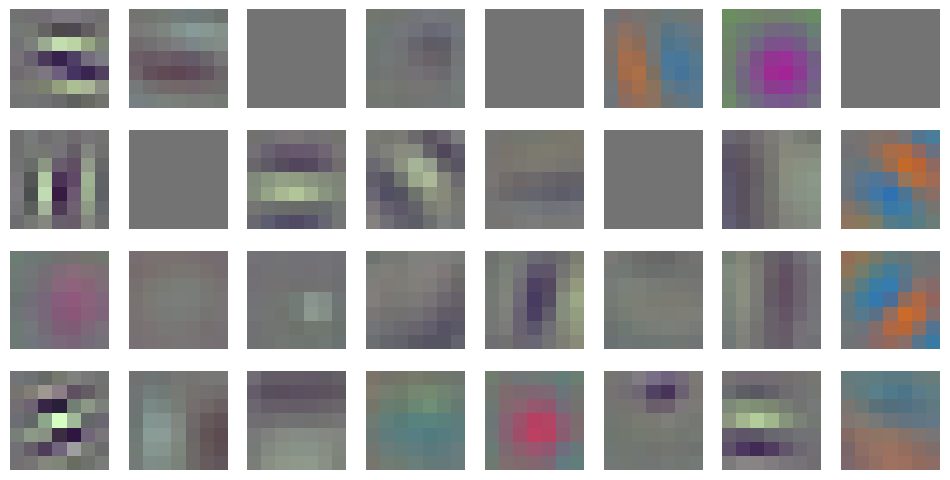

In [4]:
import matplotlib.pyplot as plt

def visualize_filters(conv_layer):
    weights = conv_layer.weight.data.cpu()
    weights = (weights - weights.min()) / (weights.max() - weights.min())

    fig, axs = plt.subplots(4, 8, figsize=(12,6))
    for i, ax in enumerate(axs.flat):
        if i < weights.shape[0]:
            ax.imshow(weights[i].permute(1,2,0))
        ax.axis('off')
    plt.show()

visualize_filters(model.conv1)

Problem 3

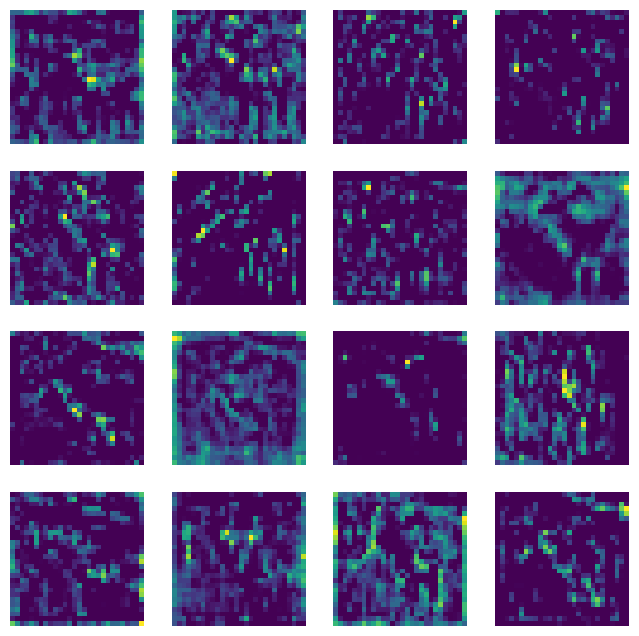

In [5]:
activation = {}

def hook_fn(module, input, output):
    activation['feature_maps'] = output.detach()

model.layer2.register_forward_hook(hook_fn)

_ = model(images)
feature_maps = activation['feature_maps'][0]

fig, axs = plt.subplots(4, 4, figsize=(8,8))
for i, ax in enumerate(axs.flat):
    ax.imshow(feature_maps[i].cpu(), cmap='viridis')
    ax.axis('off')
plt.show()

Problem 4

In [6]:
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, class_idx):
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)[0].cpu().detach().numpy()
        cam = cv2.resize(cam, (224,224))
        cam = cam / cam.max()
        return cam

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


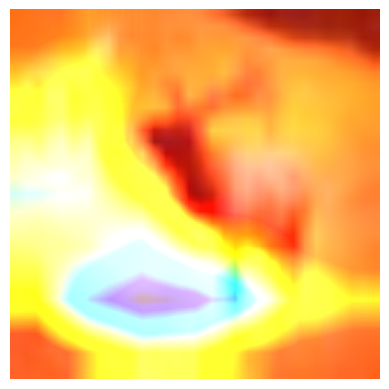

In [7]:
for param in model.layer4.parameters():
    param.requires_grad = True

gradcam = GradCAM(model, model.layer4)

outputs = model(images)
class_idx = outputs.argmax().item()

model.zero_grad()
outputs[0, class_idx].backward()

cam = gradcam.generate(class_idx)

img = images[0].permute(1,2,0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
overlay = heatmap/255 + img

plt.imshow(overlay)
plt.axis('off')
plt.show()

Problem 5

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


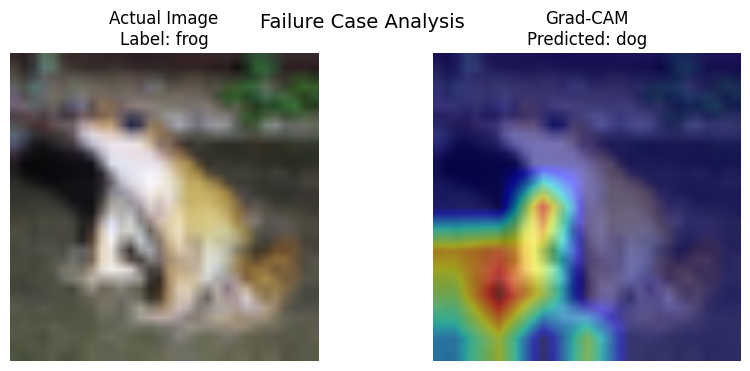

In [9]:
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = (img * std) + mean
    img = np.clip(img, 0, 1)
    return img


model.eval()

for images, labels in testloader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    pred = torch.argmax(outputs, 1)

    if pred.item() != labels.item():
        # Perform backward pass to get gradients for GradCAM
        model.zero_grad()
        # backpropagate for the predicted class
        outputs[0, pred.item()].backward()

        cam = gradcam.generate(pred.item())

        img = denormalize(images[0])

        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        axs[0].imshow(img)
        axs[0].set_title(f"Actual Image\nLabel: {classes[labels.item()]}")
        axs[0].axis('off')

        axs[1].imshow(img)
        axs[1].imshow(cam, cmap='jet', alpha=0.5)
        axs[1].set_title(f"Grad-CAM\nPredicted: {classes[pred.item()]}")
        axs[1].axis('off')

        plt.suptitle("Failure Case Analysis", fontsize=14)
        plt.show()
        break